# Exploratory Data Analysys, Feature Engineering, & Feature Reduction

Previously the data was downloaded, combined into one file, and cleaned. 

We can now perform some exploration, engineer features, and reduce features. 

Let's load the data.

In [1]:
import sys; 
sys.path.append("../..")
import pandas as pd

clean_df = pd.read_csv("../generated_data/clean_finance_data.csv", index_col='date')
clean_df

,comodities__DHHNGSP__DHHNGSP,comodities__fredgraph__DCOILBRENTEU,comodities__fredgraph__MHHNGSP,comodities__DCOILWTICO__DCOILWTICO,interest_&_credit__DGS10__DGS10,interest_&_credit__DGS2__DGS2,interest_&_credit__CPN3M__CPN3M,interest_&_credit__DGS1__DGS1,interest_&_credit__DGS5__DGS5,interest_&_credit__DBAA__DBAA,...,SPY_vwap,SPY_transactions,FX_AUDUSD_close,FX_EURUSD_close,FX_GBPUSD_close,FX_NZDUSD_close,FX_USDCAD_close,FX_USDCHF_close,FX_USDJPY_close,FX_USDSEK_close
date,,,,,,,,,,,,,,,,,,,,,
2020-09-03,2.32,40.91,1.92,41.39,0.63,0.13,0.12,0.12,0.24,3.27,...,348.2010,867631.0,0.733111,1.184736,1.335131,0.676750,1.30446,0.91118,106.208000,8.71406
2020-09-04,1.80,40.91,1.92,39.69,0.72,0.14,0.12,0.13,0.30,3.40,...,341.7648,795603.0,0.725584,1.183978,1.326225,0.668910,1.31397,0.91004,106.085999,8.74122
2020-09-05,1.80,40.91,1.92,39.69,0.72,0.14,0.12,0.13,0.30,3.40,...,341.7648,795603.0,0.725584,1.183978,1.326225,0.668910,1.31397,0.91004,106.085999,8.74122
2020-09-06,1.80,40.91,1.92,39.69,0.72,0.14,0.12,0.13,0.30,3.40,...,341.7648,795603.0,0.725584,1.183978,1.326225,0.668910,1.31397,0.91004,106.085999,8.74122
2020-09-07,1.80,40.91,1.92,39.69,0.72,0.14,0.12,0.13,0.30,3.40,...,341.7648,795603.0,0.728221,1.183446,1.324574,0.671290,1.30757,0.91357,106.310997,8.73689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-01,3.96,68.13,3.42,71.61,4.17,3.87,4.32,4.01,3.91,5.90,...,559.1036,603800.0,0.624189,1.081888,1.292090,0.567051,1.43907,0.88382,149.912994,10.03998
2025-04-02,4.04,68.13,3.42,72.12,4.20,3.91,4.32,4.04,3.95,5.93,...,560.9113,686534.0,0.628958,1.079599,1.292307,0.571389,1.42921,0.88340,149.783005,10.01032
2025-04-03,4.21,68.13,3.42,67.43,4.06,3.71,4.32,3.92,3.75,5.95,...,543.2540,1198719.0,0.626470,1.090869,1.304631,0.572761,1.42165,0.87679,147.871994,9.86130


We should verify the data is clean.

In [2]:
clean_df.index = pd.to_datetime(clean_df.index, errors="coerce")
clean_df = clean_df.sort_index()

expected = pd.date_range(start=clean_df.index.min(),
                         end=clean_df.index.max(),
                         freq="D") 

missing = expected.difference(clean_df.index)
print("Number of missing dates:", len(missing))
print("Sample missing:", missing[:10])


Number of missing dates: 0
Sample missing: DatetimeIndex([], dtype='datetime64[ns]', freq='D')


Now we look at the shape.

In [3]:
clean_df.shape

(1676, 71)

The dataset contains 1676 rows, and 71 columns. 

We can also check the organization and range of the data. 

In [4]:
dup_dates = clean_df.index[clean_df.index.duplicated()]
print("Number of duplicate timestamps:", dup_dates.size)

Number of duplicate timestamps: 0


In [5]:
is_sorted = clean_df.index.is_monotonic_increasing
print(is_sorted)

True


In [6]:
idx = pd.to_datetime(clean_df.index, errors="coerce")
dmin, dmax = idx.min(), idx.max()
nrows = idx.notna().sum()

print(f"Date range: {dmin.date()} → {dmax.date()}  | rows: {nrows - 1:,}")

Date range: 2020-09-03 → 2025-04-05  | rows: 1,675


The data ranges from late 2020 to early 2025 and contains 1675 days of information. 

What data types make up this dataset?

In [7]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1676 entries, 2020-09-03 to 2025-04-05
Data columns (total 71 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   comodities__DHHNGSP__DHHNGSP                           1676 non-null   float64
 1   comodities__fredgraph__DCOILBRENTEU                    1676 non-null   float64
 2   comodities__fredgraph__MHHNGSP                         1676 non-null   float64
 3   comodities__DCOILWTICO__DCOILWTICO                     1676 non-null   float64
 4   interest_&_credit__DGS10__DGS10                        1676 non-null   float64
 5   interest_&_credit__DGS2__DGS2                          1676 non-null   float64
 6   interest_&_credit__CPN3M__CPN3M                        1676 non-null   float64
 7   interest_&_credit__DGS1__DGS1                          1676 non-null   float64
 8   interest_&_credit__DGS5__DGS5 

The current features are all numerical. Now that we have verified the basic format of our data let's create some additional features. 

In [8]:
import pandas as pd
import numpy as np

print("Initial shape:", clean_df.shape)

windows = [5, 10, 21]
feature_df = clean_df.copy()
numeric_cols = feature_df.select_dtypes(include=[np.number]).columns

new_feature_dfs = []

for col in numeric_cols:
    for window in windows:
        temp = pd.DataFrame(index=feature_df.index)

        roll = feature_df[col].rolling(window=window, min_periods=window)

        # Rolling statistics
        temp[f'{col}_rollmean_{window}'] = roll.mean()
        temp[f'{col}_rollstd_{window}'] = roll.std()
        temp[f'{col}_rollmin_{window}'] = roll.min()
        temp[f'{col}_rollmax_{window}'] = roll.max()
        temp[f'{col}_rollmedian_{window}'] = roll.median()
        temp[f'{col}_rollrange_{window}'] = roll.max() - roll.min()
        temp[f'{col}_roll_mean_abs_dev_{window}'] = roll.apply(lambda x: np.mean(np.abs(x - np.mean(x))), raw=True)
        temp[f'{col}_roll_skew_{window}'] = roll.skew()
        temp[f'{col}_roll_kurt_{window}'] = roll.kurt()

        # EMA
        temp[f'{col}_ema_{window}'] = feature_df[col].ewm(span=window, adjust=False).mean()

        new_feature_dfs.append(temp)

# Combine all features
feature_df = pd.concat([feature_df] + new_feature_dfs, axis=1)

# Interaction features
interaction_df = pd.DataFrame(index=feature_df.index)
interaction_df['yield_spread_10y_2y'] = feature_df['interest_&_credit__DGS10__DGS10'] - feature_df['interest_&_credit__DGS2__DGS2']
interaction_df['oil_spread_wti_brent'] = feature_df['comodities__DCOILWTICO__DCOILWTICO'] - feature_df['comodities__fredgraph__DCOILBRENTEU']
interaction_df['spy_oil_ratio'] = feature_df['SPY_close'] / feature_df['comodities__DCOILWTICO__DCOILWTICO']
interaction_df['spy_m2_ratio'] = feature_df['SPY_close'] / feature_df['mon_conditions__M2SL__M2SL']
interaction_df['usd_index_vs_eur'] = feature_df['FX_USDCHF_close'] / feature_df['FX_EURUSD_close']

# Combine interaction features
feature_df = pd.concat([feature_df, interaction_df], axis=1)

# Replace inf/-inf with NaN (but no dropping yet)
feature_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Save to `clean_df` for next step
clean_df = feature_df.copy()

print("Feature shape before dropna:", clean_df.shape)


Initial shape: (1676, 71)
Feature shape before dropna: (1676, 2206)


We created 2135 additional features. 

Let's continue with regime based feature engineering. This is the feature we will be aiming to predict.

In [9]:
import numpy as np
import pandas as pd

print("Initial shape (before labeling):", clean_df.shape)

df = clean_df.copy()
window = 7 

# -----------------------------
# 1. Compute returns and volatility
# -----------------------------
df["ret"] = np.log(df["SPY_close"]).diff()
df["avg_ret"] = df["ret"].rolling(window).mean()
df["avg_vol"] = df["ret"].rolling(window).std()

# -----------------------------
# 2. Expanding (no-lookahead) normalization
# -----------------------------
df["ret_mean_exp"] = df["avg_ret"].expanding().mean()
df["ret_std_exp"] = df["avg_ret"].expanding().std()
df["vol_mean_exp"] = df["avg_vol"].expanding().mean()
df["vol_std_exp"] = df["avg_vol"].expanding().std()

df["ret_z_exp"] = (df["avg_ret"] - df["ret_mean_exp"]) / df["ret_std_exp"]
df["vol_z_exp"] = (df["avg_vol"] - df["vol_mean_exp"]) / df["vol_std_exp"]

# -----------------------------
# 3. Label regimes (no lookahead)
# -----------------------------
def bin_return(row):
    if row["ret_z_exp"] > 0.75:      # way above normal
        return "UpHard"
    elif row["ret_z_exp"] > 0.25:    # mildly above
        return "UpMild"
    elif row["ret_z_exp"] < -0.75:   # way below normal
        return "DownHard"
    elif row["ret_z_exp"] < -0.25:   # mildly below
        return "DownMild"
    else:
        return "Neutral"

def bin_vol(row):
    return "HighVol" if row["vol_z_exp"] > 0 else "LowVol"

df["regime_ret"] = df.apply(bin_return, axis=1)
df["regime_vol"] = df.apply(bin_vol, axis=1)
df["regime"] = df["regime_ret"] + "_" + df["regime_vol"]

# -----------------------------
# 4. Final cleanup
# -----------------------------
df.dropna(inplace=True)

print("Final shape after feature additions, regime, and dropna:", df.shape)
print("\nClass distribution of regimes:")
print(df["regime"].value_counts())

# Final clean dataset
clean_df = df.copy()

Initial shape (before labeling): (1676, 2206)
Final shape after feature additions, regime, and dropna: (1656, 2218)

Class distribution of regimes:
regime
UpMild_LowVol       311
Neutral_LowVol      296
DownHard_HighVol    234
DownMild_LowVol     182
UpHard_LowVol       147
UpHard_HighVol      116
DownHard_LowVol     105
UpMild_HighVol       95
Neutral_HighVol      88
DownMild_HighVol     82
Name: count, dtype: int64


Let's visualize the distribution of Regimes.

Regime distribution:
          Regime  Percent
   UpMild_LowVol    18.78
  Neutral_LowVol    17.87
DownHard_HighVol    14.13
 DownMild_LowVol    10.99
   UpHard_LowVol     8.88
  UpHard_HighVol     7.00
 DownHard_LowVol     6.34
  UpMild_HighVol     5.74
 Neutral_HighVol     5.31
DownMild_HighVol     4.95


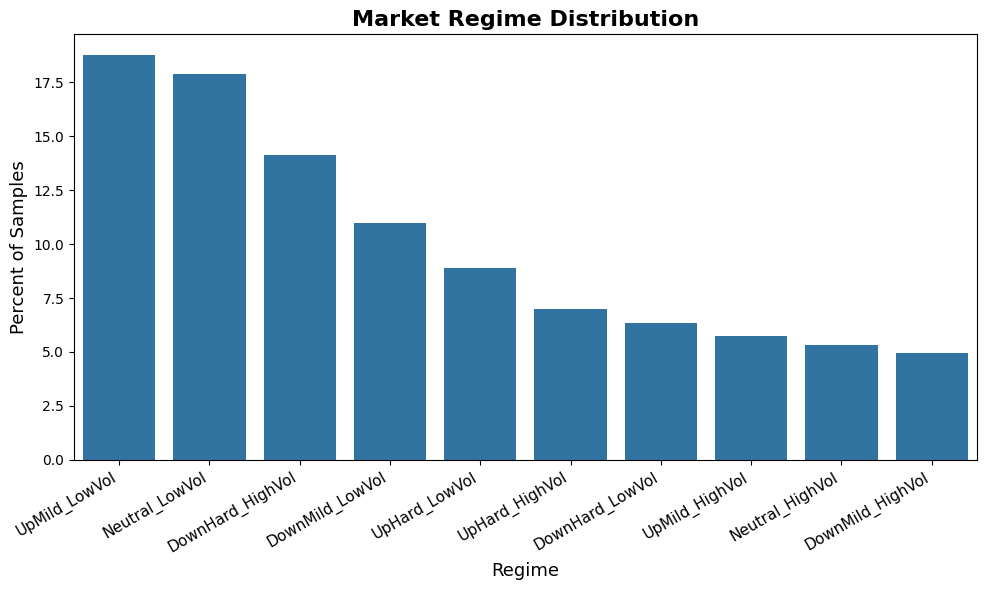


Naïve baseline accuracy (always predict majority class): 18.78%


In [10]:
# ==========================================
# BASELINE REGIME DISTRIBUTION (Percentage)
# ==========================================
import matplotlib.pyplot as plt
import seaborn as sns

# --- Compute normalized distribution ---
regime_dist = (
    df["regime"].value_counts(normalize=True)
    .mul(100)
    .rename_axis("Regime")  
    .reset_index(name="Percent")
    .sort_values("Percent", ascending=False)
)

# --- Print for reference ---
print("Regime distribution:")
print(regime_dist.to_string(index=False, float_format="%.2f"))

# --- Plot ---
plt.figure(figsize=(10, 6))
sns.barplot(
    data=regime_dist,
    x="Regime",
    y="Percent",
)

plt.title("Market Regime Distribution", fontsize=16, weight="bold")
plt.xlabel("Regime", fontsize=13)
plt.ylabel("Percent of Samples", fontsize=13)
plt.xticks(rotation=30, ha="right", fontsize=11)
plt.tight_layout()
plt.show()

# --- Optional: Naïve baseline accuracy ---
naive_accuracy = regime_dist["Percent"].max() / 100
print(f"\nNaïve baseline accuracy (always predict majority class): {naive_accuracy:.2%}")


From the regime distribution plot, we can see that our baseline model needs to predict with an accuracy above `18.78%` to be considered better than random and successful. 

We can further visualize scatter plots of regime clusters to see how regimes separate by volatility and return bins. 

We will first visualize global regimes, then visualize our rolling (non-future leaking) regimes. 

Global regime class distribution:
regime_global
UpMild_LowVol       379
DownMild_LowVol     228
Neutral_LowVol      226
DownHard_HighVol    203
UpMild_HighVol      153
DownMild_HighVol    131
UpHard_HighVol      112
UpHard_LowVol        86
Neutral_HighVol      85
DownHard_LowVol      53
Name: count, dtype: int64


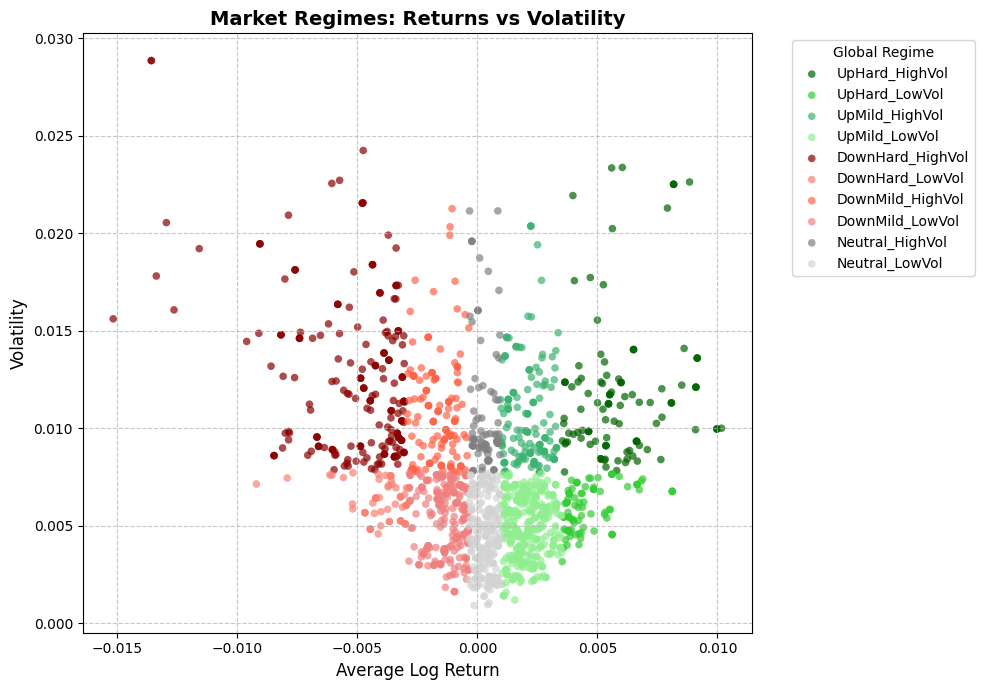

In [11]:
# ==========================================
# GLOBAL REGIME CALCULATION + VISUALIZATION
# ==========================================
import matplotlib.pyplot as plt
import seaborn as sns

# --- Global normalization ---
df["ret_z_global"] = (df["avg_ret"] - df["avg_ret"].mean()) / df["avg_ret"].std()
df["vol_z_global"] = (df["avg_vol"] - df["avg_vol"].mean()) / df["avg_vol"].std()

# --- Regime labeling ---
def bin_return_global(row):
    if row["ret_z_global"] > 1.0:
        return "UpHard"
    elif row["ret_z_global"] > 0.2:
        return "UpMild"
    elif row["ret_z_global"] < -1.0:
        return "DownHard"
    elif row["ret_z_global"] < -0.2:
        return "DownMild"
    else:
        return "Neutral"

def bin_vol_global(row):
    return "HighVol" if row["vol_z_global"] > 0 else "LowVol"

df["regime_ret_global"] = df.apply(bin_return_global, axis=1)
df["regime_vol_global"] = df.apply(bin_vol_global, axis=1)
df["regime_global"] = df["regime_ret_global"] + "_" + df["regime_vol_global"]

print("Global regime class distribution:")
print(df["regime_global"].value_counts())

# Readable label map
label_map = {
    "UpHard_HighVol": "Strong Postive Returns / High Volatility",
    "UpHard_LowVol": "Strong Postive Returns / Low Volatility",
    "UpMild_HighVol": "Mild Postive Returns / High Volatility",
    "UpMild_LowVol": "Mild Postive Returns / Low Volatility",
    "DownHard_HighVol": "Strong Negative Returns / High Volatility",
    "DownHard_LowVol": "Strong Negative Returns / Low Volatility",
    "DownMild_HighVol": "Mild Negative Returns / High Volatility",
    "DownMild_LowVol": "Mild Negative Returns / Low Volatility",
    "Neutral_HighVol": "Neutral Returns / High Volatility",
    "Neutral_LowVol": "Neutral Returns / Low Volatility"
}
df["regime_label"] = df["regime_global"].map(label_map)

# --- Regime Scatter Plot ---
regime_colors = {
    "UpHard_HighVol": "darkgreen",
    "UpHard_LowVol": "limegreen",
    "UpMild_HighVol": "mediumseagreen",
    "UpMild_LowVol": "lightgreen",
    "DownHard_HighVol": "darkred",
    "DownHard_LowVol": "salmon",
    "DownMild_HighVol": "tomato",
    "DownMild_LowVol": "lightcoral",
    "Neutral_HighVol": "gray",
    "Neutral_LowVol": "lightgray"
}

plt.figure(figsize=(10, 7))
for regime, color in regime_colors.items():
    subset = df[df["regime_global"] == regime]
    plt.scatter(subset["avg_ret"], subset["avg_vol"],
                color=color, label=regime, alpha=0.7, s=30, edgecolor='none')

plt.title("Market Regimes: Returns vs Volatility", fontsize=14, weight="bold")
plt.xlabel("Average Log Return", fontsize=12)
plt.ylabel("Volatility", fontsize=12)
plt.legend(title="Global Regime", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


We will be attempting to predict future regimes. Knowing this, the regime classes appear to be somewhat evenely distributed, although classes 5 and 6 are slightly less common then the rest of the classes. We can visulize regimes to gain more insight. 

Expanding regime class distribution:
regime
UpMild_LowVol       311
Neutral_LowVol      296
DownHard_HighVol    234
DownMild_LowVol     182
UpHard_LowVol       147
UpHard_HighVol      116
DownHard_LowVol     105
UpMild_HighVol       95
Neutral_HighVol      88
DownMild_HighVol     82
Name: count, dtype: int64


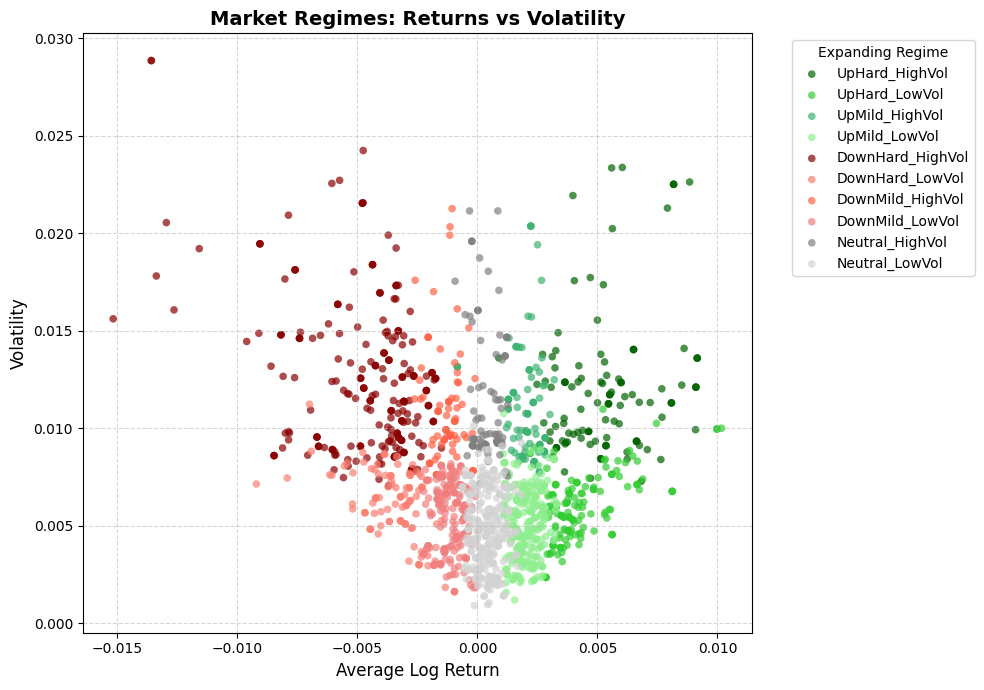

In [12]:
# ==========================================
# EXPANDING (NO-LOOKAHEAD) REGIME VISUALIZATION
# ==========================================
import matplotlib.pyplot as plt
import seaborn as sns

# --- Readable label mapping ---
label_map = {
    "UpHard_HighVol": "Strong Postive Returns / High Volatility",
    "UpHard_LowVol": "Strong Postive Returns / Low Volatility",
    "UpMild_HighVol": "Mild Postive Returns / High Volatility",
    "UpMild_LowVol": "Mild Postive Returns / Low Volatility",
    "DownHard_HighVol": "Strong Negative Returns / High Volatility",
    "DownHard_LowVol": "Strong Negative Returns / Low Volatility",
    "DownMild_HighVol": "Mild Negative Returns / High Volatility",
    "DownMild_LowVol": "Mild Negative Returns / Low Volatility",
    "Neutral_HighVol": "Neutral Returns / High Volatility",
    "Neutral_LowVol": "Neutral Returns / Low Volatility"
}
df["regime_label"] = df["regime"].map(label_map)

# --- Colors ---
regime_colors = {
    "UpHard_HighVol": "darkgreen",
    "UpHard_LowVol": "limegreen",
    "UpMild_HighVol": "mediumseagreen",
    "UpMild_LowVol": "lightgreen",
    "DownHard_HighVol": "darkred",
    "DownHard_LowVol": "salmon",
    "DownMild_HighVol": "tomato",
    "DownMild_LowVol": "lightcoral",
    "Neutral_HighVol": "gray",
    "Neutral_LowVol": "lightgray"
}

print("Expanding regime class distribution:")
print(df["regime"].value_counts())

# --- Plot 1: Regime scatter ---
plt.figure(figsize=(10, 7))
for regime, color in regime_colors.items():
    subset = df[df["regime"] == regime]
    plt.scatter(subset["avg_ret"], subset["avg_vol"],
                color=color, label=regime, alpha=0.7, s=30, edgecolor='none')

plt.title("Market Regimes: Returns vs Volatility",
          fontsize=14, weight="bold")
plt.xlabel("Average Log Return", fontsize=12)
plt.ylabel("Volatility", fontsize=12)
plt.legend(title="Expanding Regime", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



While there are differences between the global and rolling regime clusters we can see they are similar in how they group over time.

In [13]:
# Encode regimes as integers
regime_map = {label: i+1 for i, label in enumerate(sorted(df["regime"].unique()))}
df["regime"] = df["regime"].map(regime_map)

Now by looking at the regimes over time (below) in the SPY index we can see they appear somewhat naturally distributed (there are no obvious blocks over any specific time period).

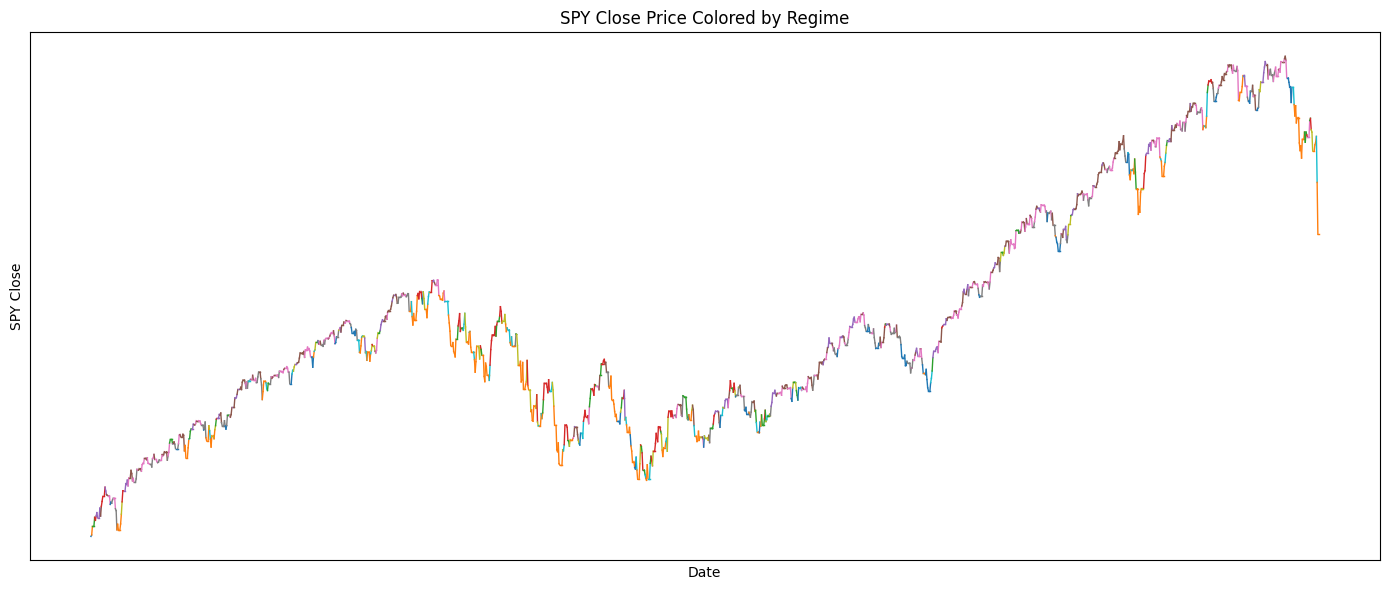

In [14]:
import matplotlib.pyplot as plt
import matplotlib as mpl

regimes = df["regime"].unique()
colors = dict(zip(regimes, plt.cm.tab10.colors[:len(regimes)]))
plt.figure(figsize=(14,6))
for i in range(len(df)-1):
    regime = df["regime"].iloc[i]
    plt.plot(
        df.index[i:i+2], 
        df["SPY_close"].iloc[i:i+2],
        color=colors[regime],
        lw=1
    )

plt.title("SPY Close Price Colored by Regime")
plt.xlabel("Date")
plt.ylabel("SPY Close")
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

We should also take a look at some KDE plots and timeseries plots for a sample of the features we have in this dataset.

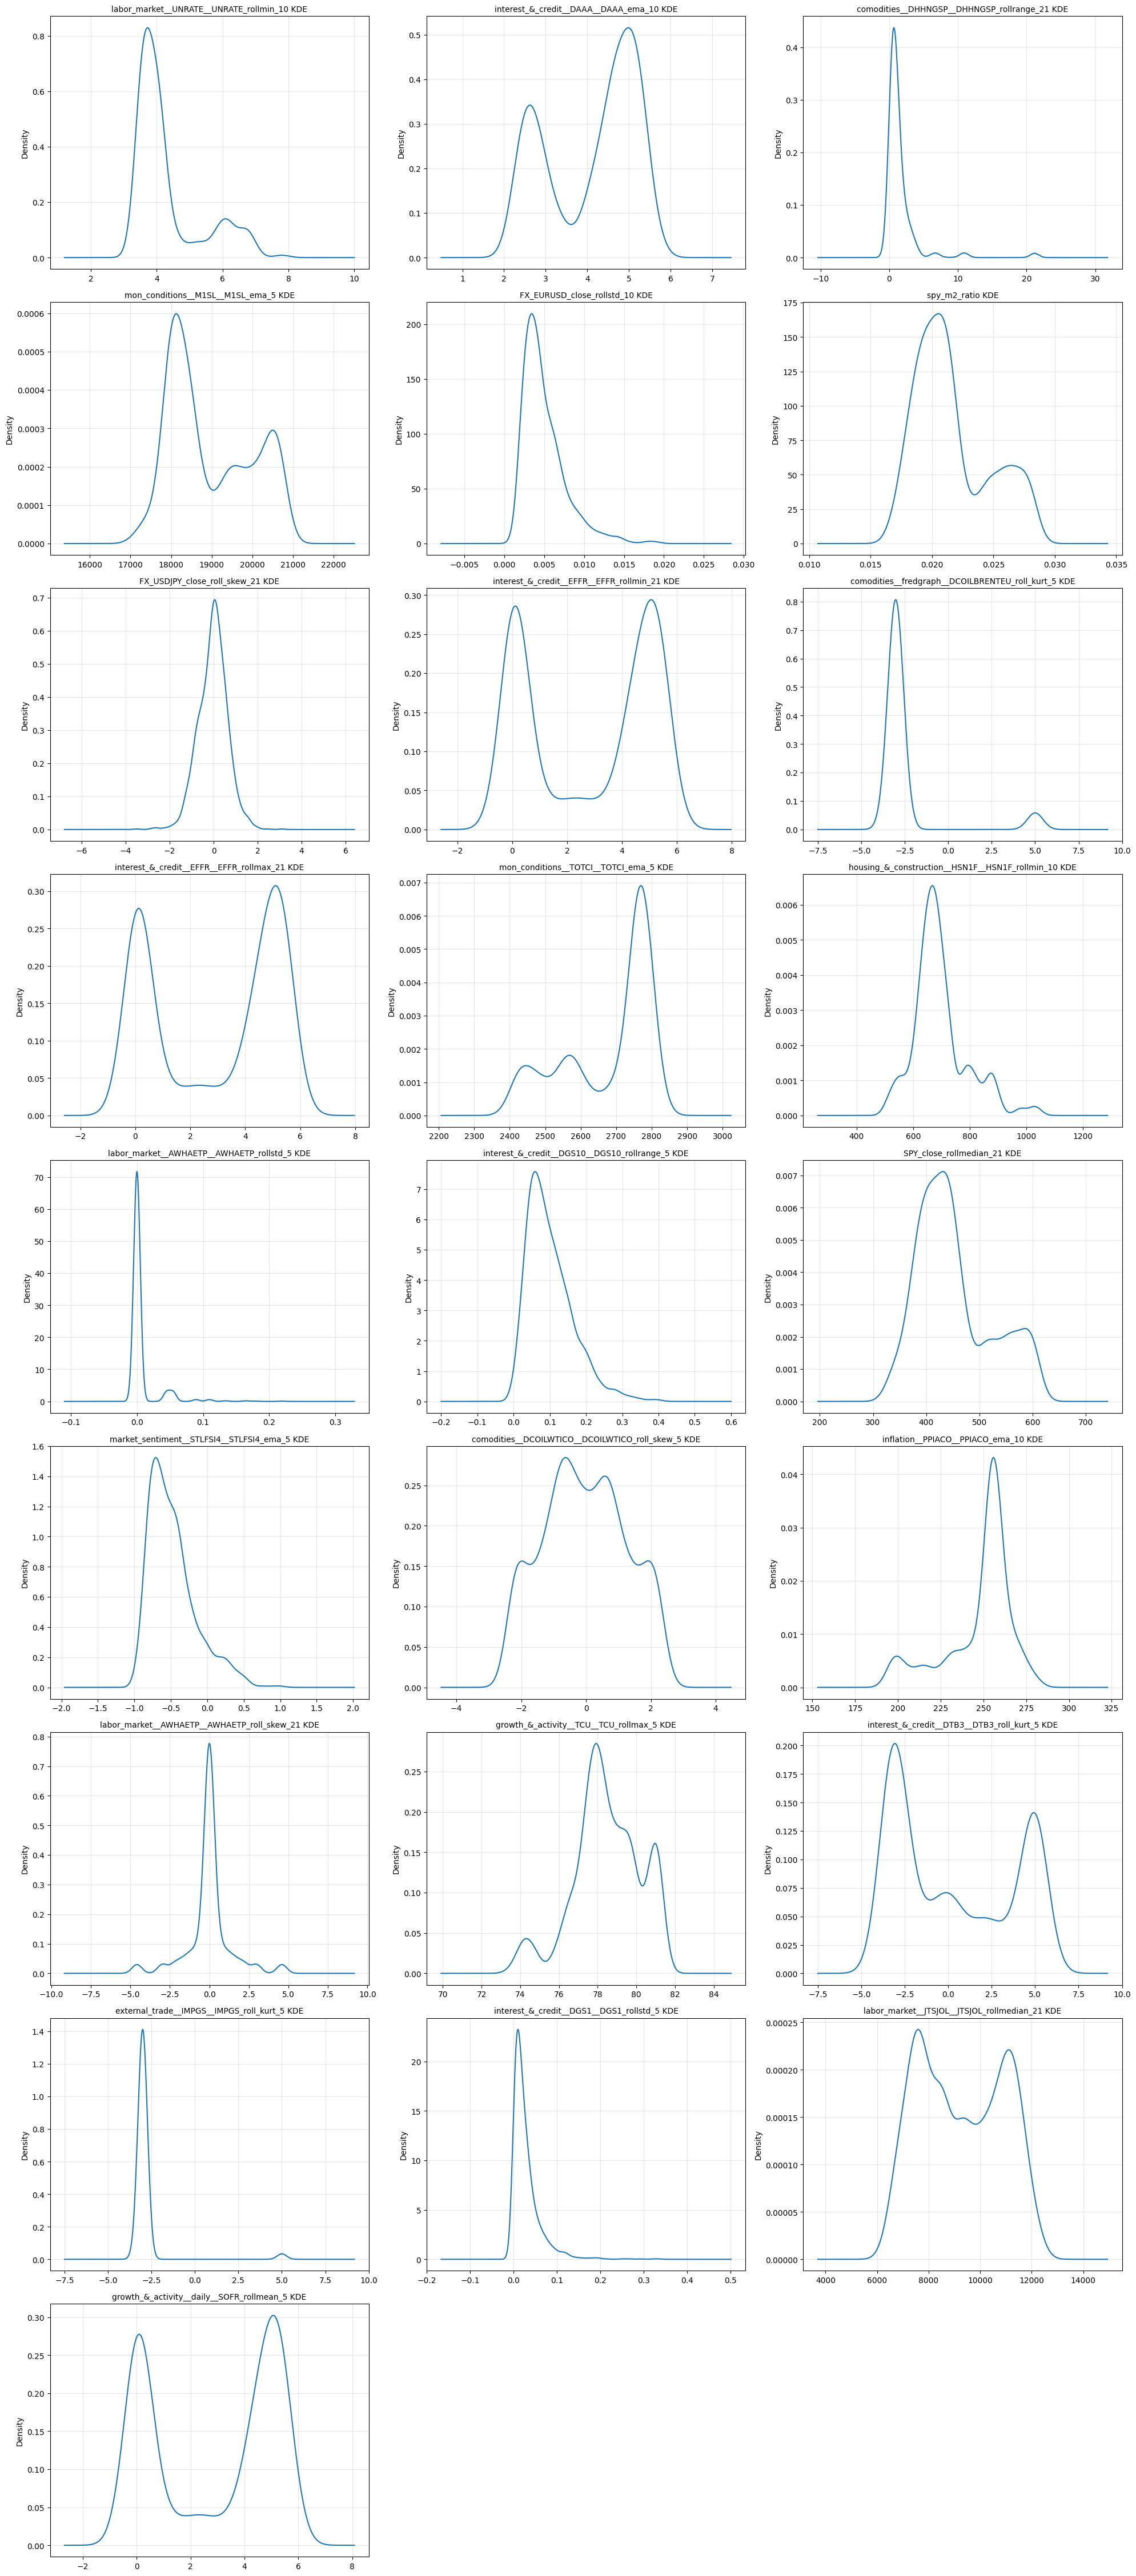

In [15]:
import matplotlib.pyplot as plt
import numpy as np

n_cols_to_plot = 25
numeric_cols = df.select_dtypes(include=np.number).columns

np.random.seed(42)
sampled_cols = np.random.choice(numeric_cols, size=min(n_cols_to_plot, len(numeric_cols)), replace=False)

fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(20, 50)) 
axes = axes.flatten()
for i, col in enumerate(sampled_cols):
    df[col].dropna().plot.kde(ax=axes[i])
    axes[i].set_title(f"{col} KDE", fontsize=10)
    axes[i].grid(True, alpha=0.3)

for j in range(len(sampled_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


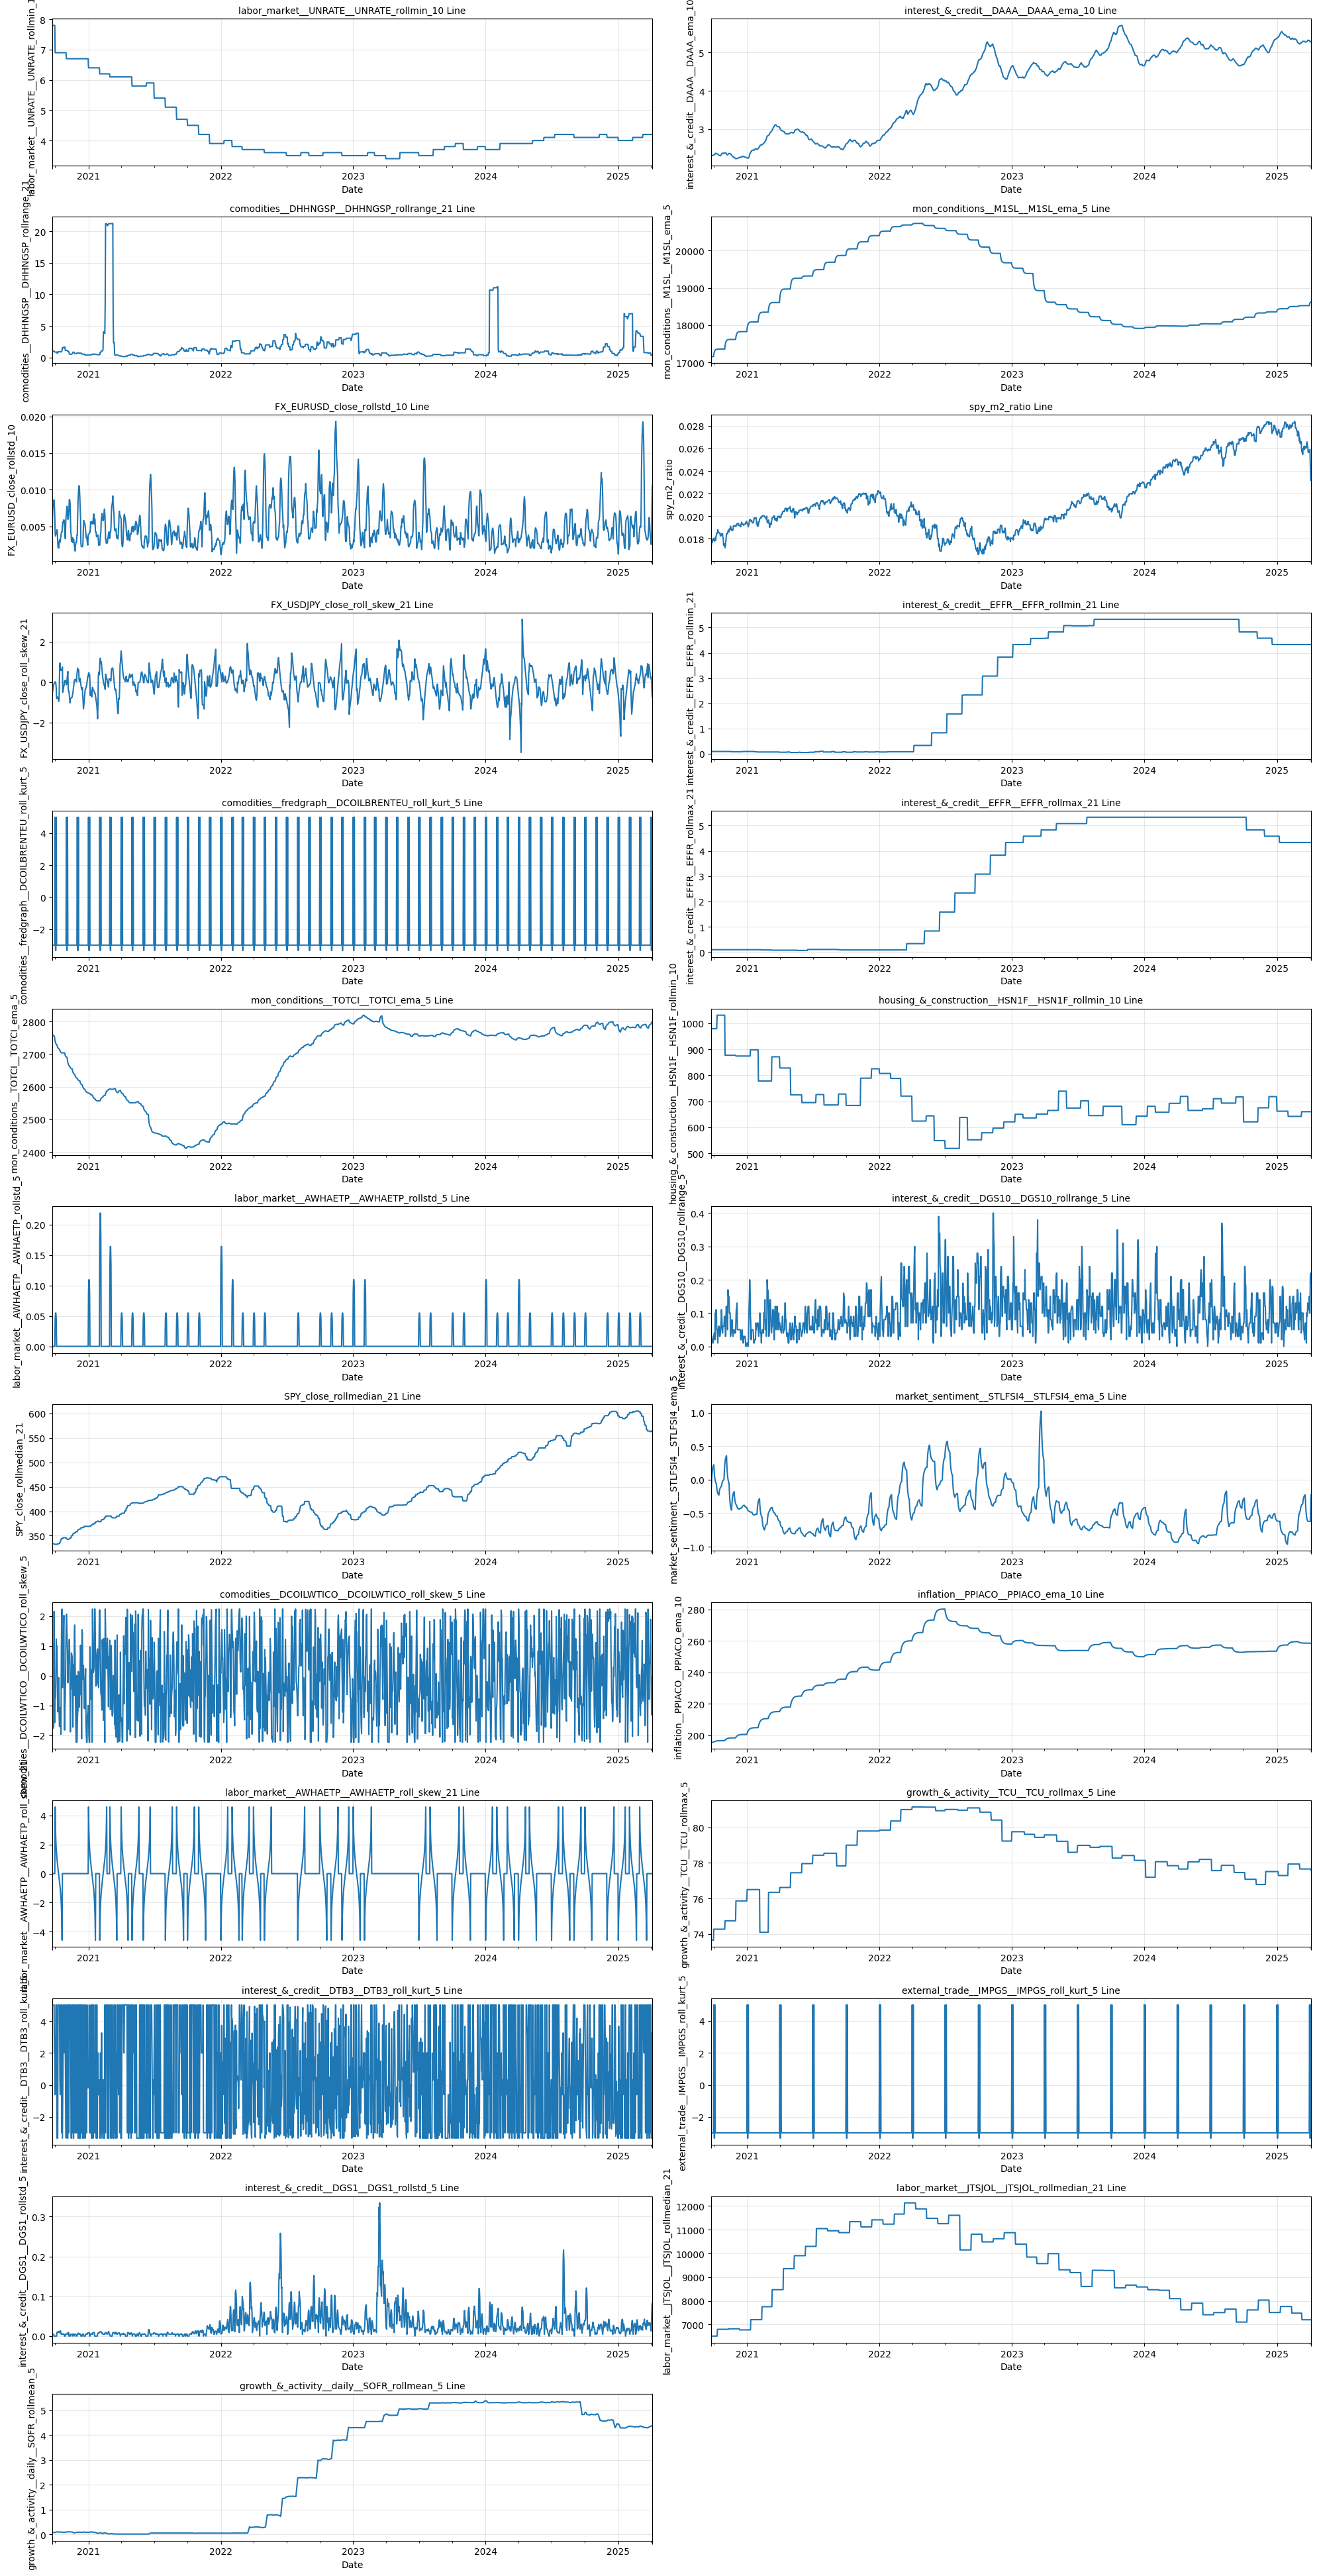

In [16]:
import matplotlib.pyplot as plt
import numpy as np

n_cols_to_plot = 25 
numeric_cols = df.select_dtypes(include="number").columns

np.random.seed(42)
sampled_cols = np.random.choice(numeric_cols, size=min(n_cols_to_plot, len(numeric_cols)), replace=False)

rows = int(np.ceil(len(sampled_cols) / 2))
fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=(20, rows * 3))
axes = axes.flatten()

for i, col in enumerate(sampled_cols):
    df[col].dropna().plot(ax=axes[i])
    axes[i].set_title(f"{col} Line", fontsize=10)
    axes[i].set_xlabel("Date")
    axes[i].set_ylabel(col)
    axes[i].grid(True, alpha=0.3)

for j in range(len(sampled_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


We can see a range of shapes and distributions for the plots above, some features are displaying a trend and some appearing to be stationary.
 
 Since we are working with time series data we will convert all non-stationary features to stationary. 

In [17]:
import numpy as np
import pandas as pd
from utils.stationarity_tests import test_stationarity

regime = df.pop("regime")

stationarity_results = {}
processed_cols = {}

for col in df.select_dtypes(include=np.number).columns:
    series = df[col].dropna()
    diff_count = 0

    while diff_count < 3:
        try:
            result = test_stationarity(series, name=col)
        except ValueError:
            break
        if result[col]["stationary"]:
            stationarity_results[col] = {"stationary": True, "diffs_applied": diff_count}
            break
        else:
            series = series.diff().dropna()
            diff_count += 1
    else:
        stationarity_results[col] = {"stationary": False, "diffs_applied": diff_count}

    if series.std() != 0:
        series = (series - series.mean()) / series.std()

    processed_cols[col] = series.reindex(df.index)
    
df_stationary = pd.concat(processed_cols.values(), axis=1)
df_stationary.columns = list(processed_cols.keys())

df_stationary["regime"] = regime
df_stationary = df_stationary.dropna()

print(f"\nTransformed stationary + normalized dataset with {df_stationary.shape[0]} rows and {df_stationary.shape[1]} columns ")



Transformed stationary + normalized dataset with 1654 rows and 2218 columns 


Will will now save the data into train and test sets and reload them. 

In [18]:
import pandas as pd

split_idx = int(len(df_stationary) * 0.7)
train_df = df_stationary.iloc[:split_idx]
test_df = df_stationary.iloc[split_idx:]

In [19]:
train_df.shape

(1157, 2218)

The train set has 2218 inital features and 1156 days of information. 

In [20]:
test_df.shape

(497, 2218)

The test set has 2218 inital features and 496 days of information. 

Save and reload

In [21]:
train_df.to_csv("../../data/generated_data/train.csv")
test_df.to_csv("../../data/generated_data/test.csv")
train_df = pd.read_csv("../../data/generated_data/train.csv", index_col=0)
test_df = pd.read_csv("../../data/generated_data/test.csv", index_col=0)

Now that we have loaded the engineered feature data, we can start feature reduction / selection. 

For our feature reduction steps we will ONLY use training data, but update both the train and test sets as we go.

Additionally, we assume our modeling steps and feature selection steps are based on predicting regimes 3 days into the future. We chose 3 days into the future instead of the next day due to forward filling our dataset through holidays and weekends (where no data is present). 

We can start reducing our features based on a random forrest classifier using a random noise feature-importance-threshold.  

In [22]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier

train = train_df.copy()

train['shifted_regime'] = train['regime'].shift(-3)
train = train.dropna(subset=['shifted_regime'])

train_y = train['shifted_regime'].astype(int)

train_features = train.drop(columns=['shifted_regime']) 

train_X = train_features.select_dtypes(include=np.number).copy()

np.random.seed(42)
train_X['__random_noise__'] = np.random.randn(len(train_X))

rf = RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1)
rf.fit(train_X, train_y)

feature_importance = pd.Series(rf.feature_importances_, index=train_X.columns)

noise_threshold = feature_importance["__random_noise__"]
selected_features = feature_importance[feature_importance > noise_threshold].index

selected_features = selected_features.drop('__random_noise__', errors='ignore')

reduced_train_df = train_df[selected_features.to_list()].copy()

if 'regime' not in reduced_train_df.columns:
    reduced_train_df['regime'] = train_df['regime']

existing_features = [f for f in selected_features if f in test_df.columns]
reduced_test_df = test_df[existing_features].copy()

if 'regime' not in reduced_test_df.columns and 'regime' in test_df.columns:
    reduced_test_df['regime'] = test_df['regime']


print("Original train shape:", train_df.shape)
print("Filtered train shape:", reduced_train_df.shape)
print("Filtered test shape:", reduced_test_df.shape)
print(f"Kept {len(selected_features)} features better than random noise")
print("Top features:\n", selected_features.to_list())


Original train shape: (1157, 2218)
Filtered train shape: (1157, 668)
Filtered test shape: (497, 668)
Kept 668 features better than random noise
Top features:
 ['SPY_high', 'SPY_low', 'SPY_close', 'SPY_vwap', 'SPY_transactions', 'comodities__DHHNGSP__DHHNGSP_rollmean_5', 'comodities__DHHNGSP__DHHNGSP_rollstd_5', 'comodities__DHHNGSP__DHHNGSP_rollrange_5', 'comodities__DHHNGSP__DHHNGSP_roll_mean_abs_dev_5', 'comodities__DHHNGSP__DHHNGSP_roll_skew_5', 'comodities__DHHNGSP__DHHNGSP_roll_kurt_5', 'comodities__DHHNGSP__DHHNGSP_ema_5', 'comodities__DHHNGSP__DHHNGSP_rollmean_10', 'comodities__DHHNGSP__DHHNGSP_rollstd_10', 'comodities__DHHNGSP__DHHNGSP_rollrange_10', 'comodities__DHHNGSP__DHHNGSP_roll_mean_abs_dev_10', 'comodities__DHHNGSP__DHHNGSP_roll_skew_10', 'comodities__DHHNGSP__DHHNGSP_roll_kurt_10', 'comodities__DHHNGSP__DHHNGSP_ema_10', 'comodities__DHHNGSP__DHHNGSP_rollmean_21', 'comodities__DHHNGSP__DHHNGSP_rollstd_21', 'comodities__DHHNGSP__DHHNGSP_rollrange_21', 'comodities__DHHNGS

Using a random forrest classifier we reduced the feature space from 2218 to 668

Visualizing the cutoff (as shown below), we can see a large number of features provided less than random value in our predictions.

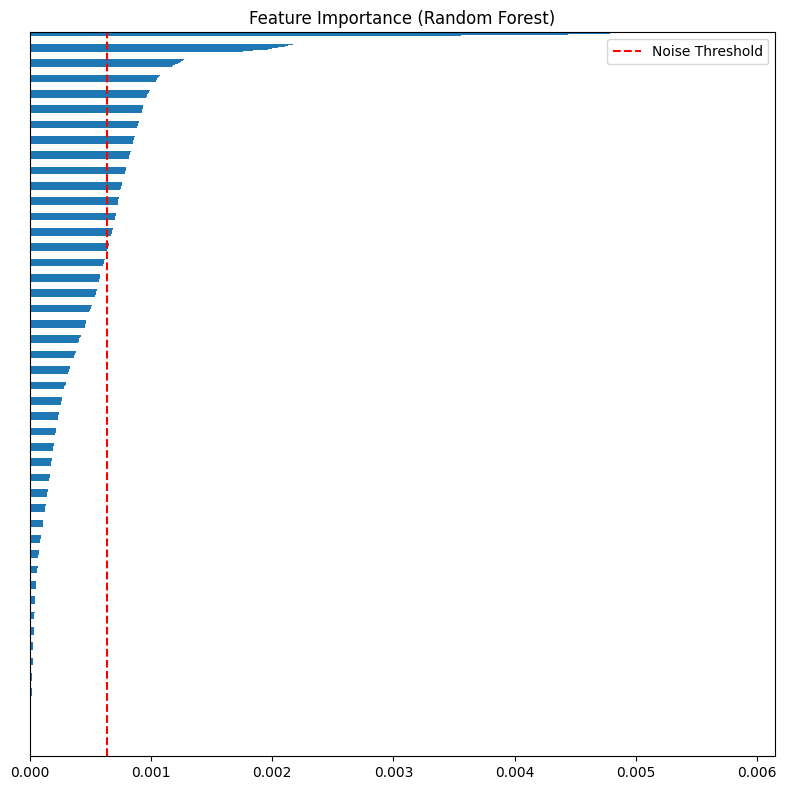

In [23]:
import matplotlib.pyplot as plt

feature_importance.sort_values().plot(kind="barh", figsize=(8, 8))
plt.axvline(x=noise_threshold, color="red", linestyle="--", label="Noise Threshold")
plt.title("Feature Importance (Random Forest)")
plt.legend()
plt.yticks([])
plt.tight_layout()
plt.show()

Save and reload. 

In [24]:
reduced_train_df.to_csv("../../data/generated_data/train.csv", index=False)
reduced_test_df.to_csv("../../data/generated_data/test.csv", index=False)

train_df = pd.read_csv("../../data/generated_data/train.csv", index_col=0)
test_df = pd.read_csv("../../data/generated_data/test.csv", index_col=0)

Now we can reduce by variance. Low variance features get removed. 

In [25]:
from sklearn.feature_selection import VarianceThreshold
import numpy as np
import pandas as pd

print("Original train shape:", train_df.shape)

# --- Separate target ---
regime_train = train_df['regime']
regime_test = test_df['regime']


X_train = train_df.select_dtypes(np.number).drop(columns=['regime'], errors='ignore')
X_test = test_df.select_dtypes(np.number).drop(columns=['regime'], errors='ignore')

selector = VarianceThreshold(threshold=1)
X_train_reduced = selector.fit_transform(X_train)

kept_features = X_train.columns[selector.get_support()]
print(f"Kept {len(kept_features)} features:")
print(kept_features.tolist())

X_test_reduced = X_test.reindex(columns=kept_features)


reduced_train_df = pd.DataFrame(X_train_reduced, columns=kept_features)
reduced_train_df["regime"] = regime_train.values 

reduced_test_df = X_test_reduced.copy()
reduced_test_df["regime"] = regime_test.values  

print("Reduced train shape:", reduced_train_df.shape)
print("Reduced test shape:", reduced_test_df.shape)


Original train shape: (1157, 667)
Kept 409 features:
['SPY_transactions', 'comodities__DHHNGSP__DHHNGSP_roll_skew_5', 'comodities__DHHNGSP__DHHNGSP_rollrange_10', 'comodities__DHHNGSP__DHHNGSP_roll_skew_10', 'comodities__DHHNGSP__DHHNGSP_rollrange_21', 'comodities__fredgraph__DCOILBRENTEU_ema_5', 'comodities__fredgraph__DCOILBRENTEU_ema_10', 'comodities__fredgraph__DCOILBRENTEU_rollmean_21', 'comodities__fredgraph__DCOILBRENTEU_ema_21', 'comodities__fredgraph__MHHNGSP_ema_5', 'comodities__fredgraph__MHHNGSP_ema_10', 'comodities__fredgraph__MHHNGSP_rollstd_21', 'comodities__fredgraph__MHHNGSP_roll_mean_abs_dev_21', 'comodities__fredgraph__MHHNGSP_ema_21', 'comodities__DCOILWTICO__DCOILWTICO_rollmean_5', 'comodities__DCOILWTICO__DCOILWTICO_roll_mean_abs_dev_5', 'comodities__DCOILWTICO__DCOILWTICO_rollmean_10', 'comodities__DCOILWTICO__DCOILWTICO_rollstd_10', 'comodities__DCOILWTICO__DCOILWTICO_rollmedian_10', 'comodities__DCOILWTICO__DCOILWTICO_roll_mean_abs_dev_10', 'comodities__DCOILWT

Using a variance threshold we reduced the feature space from 668 to 409

Save and reload

In [26]:
reduced_train_df.to_csv("../../data/generated_data/train.csv", index=False)
reduced_test_df.to_csv("../../data/generated_data/test.csv", index=False)

train_df = pd.read_csv("../../data/generated_data/train.csv", index_col=0)
test_df = pd.read_csv("../../data/generated_data/test.csv", index_col=0)

Next we will reduce features with high correlation.

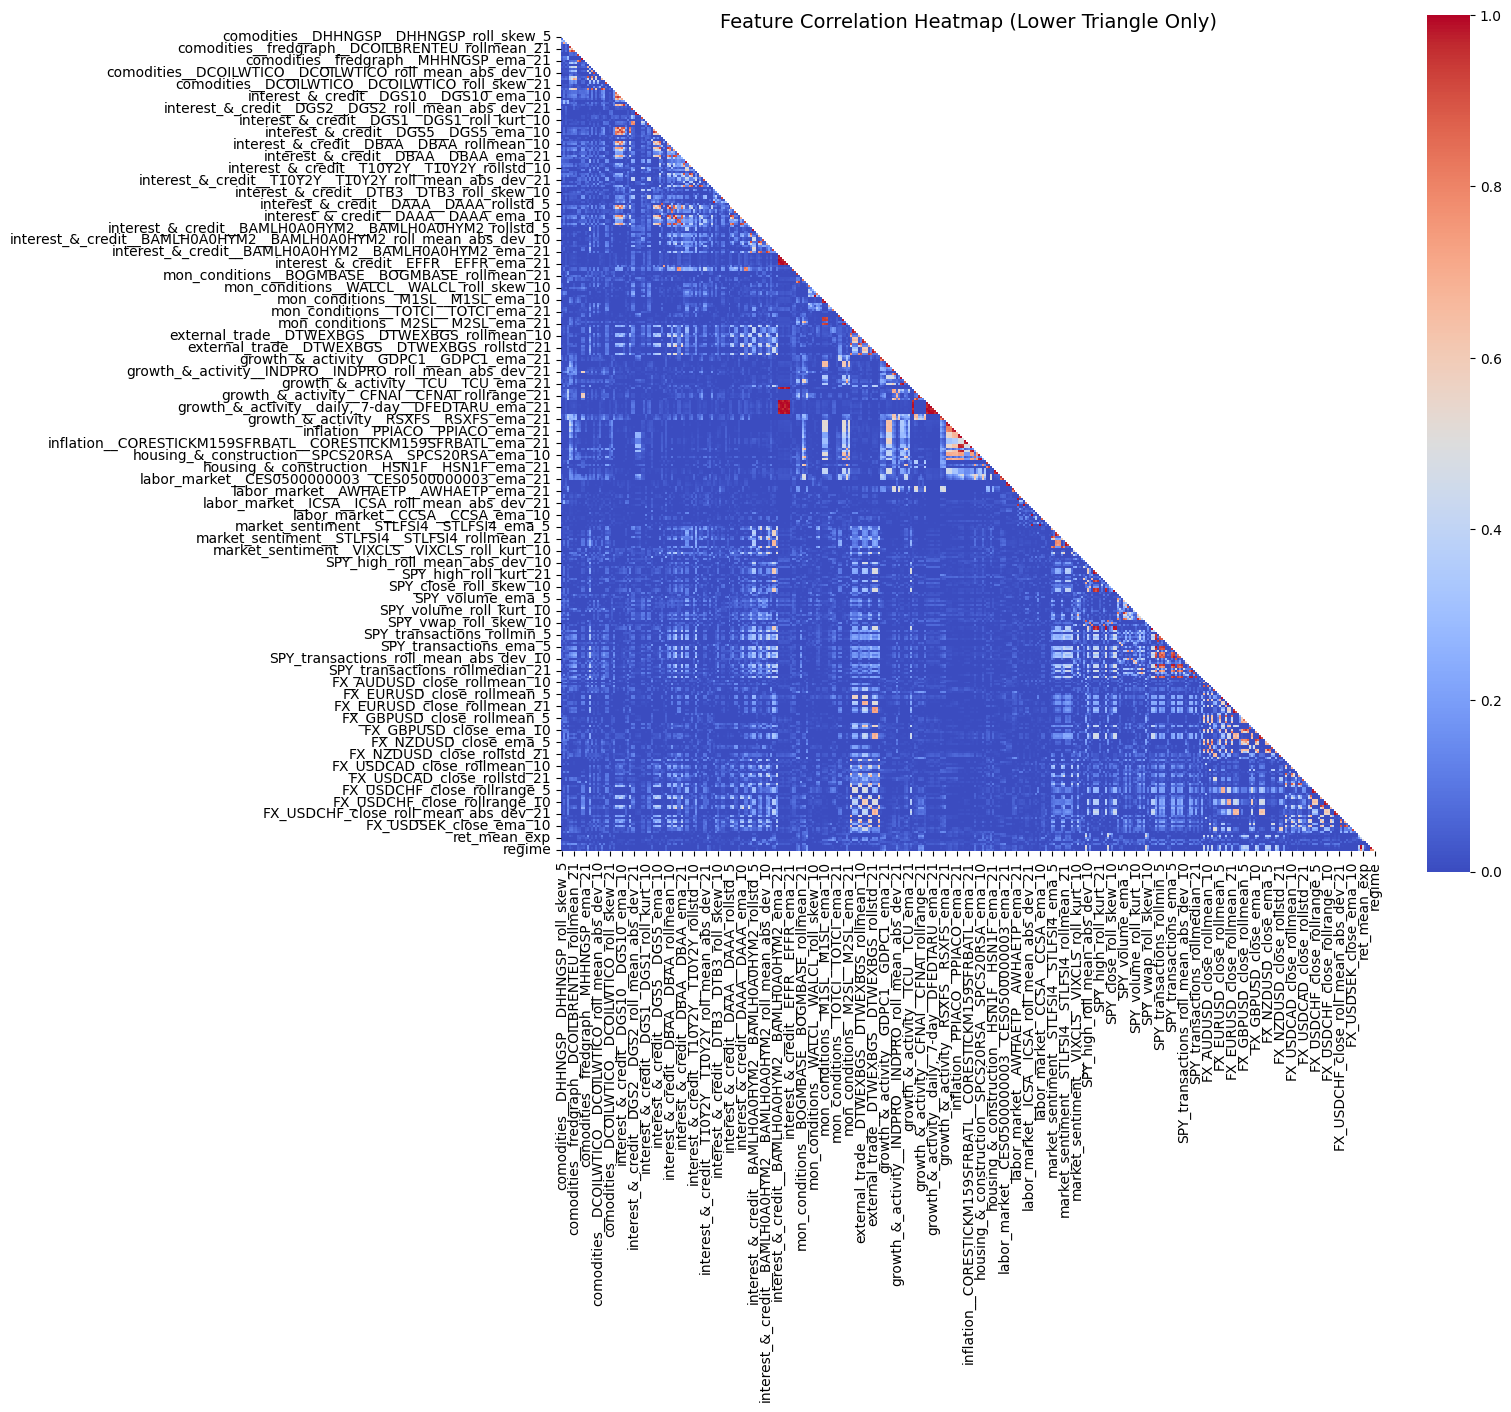

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

regime = train_df["regime"] 
df = train_df.select_dtypes(np.number)

df = train_df.select_dtypes(np.number)
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(16, 14))
sns.heatmap(
    corr,
    mask=mask,
    cmap="coolwarm",
    vmin=0,
    vmax=1,
    square=True,
)

plt.title("Feature Correlation Heatmap (Lower Triangle Only)", fontsize=14)
plt.tight_layout()
plt.show()


In [28]:
import numpy as np
import pandas as pd

print("Original train shape:", train_df.shape)

# --- Compute correlation matrix on train numeric features ---
numeric_train = train_df.select_dtypes(np.number).drop(columns=['regime'], errors='ignore')
corr = numeric_train.corr().abs()  # use absolute correlation (ignore sign)
mask = np.triu(np.ones_like(corr, dtype=bool))
upper = corr.where(mask)

# --- Identify redundant features ---
to_drop = set()
for col in upper.columns:
    for row in upper.index:
        val = upper.loc[row, col]
        if pd.notna(val) and val > 0.95:
            # keep SPY-related features; drop others
            if "SPY" not in row and "SPY" not in col:
                to_drop.add(col)

print(f"Features to drop ({len(to_drop)}):", sorted(to_drop))

# --- Drop correlated features from both train/test ---
reduced_train_df = train_df.drop(columns=to_drop, errors='ignore').copy()
reduced_test_df = test_df.drop(columns=to_drop, errors='ignore').copy()

# --- Re-add regime column if missing ---
if 'regime' not in reduced_train_df.columns and 'regime' in train_df.columns:
    reduced_train_df['regime'] = train_df['regime']

if 'regime' not in reduced_test_df.columns and 'regime' in test_df.columns:
    reduced_test_df['regime'] = test_df['regime']

print("Reduced train shape:", reduced_train_df.shape)
print("Reduced test shape:", reduced_test_df.shape)


Original train shape: (1157, 409)
Features to drop (347): ['FX_AUDUSD_close_ema_10', 'FX_AUDUSD_close_roll_kurt_5', 'FX_AUDUSD_close_roll_mean_abs_dev_21', 'FX_AUDUSD_close_roll_skew_21', 'FX_AUDUSD_close_rollmean_10', 'FX_AUDUSD_close_rollmean_5', 'FX_AUDUSD_close_rollstd_10', 'FX_AUDUSD_close_rollstd_21', 'FX_EURUSD_close_ema_21', 'FX_EURUSD_close_roll_mean_abs_dev_10', 'FX_EURUSD_close_roll_mean_abs_dev_21', 'FX_EURUSD_close_roll_mean_abs_dev_5', 'FX_EURUSD_close_roll_skew_21', 'FX_EURUSD_close_rollmean_10', 'FX_EURUSD_close_rollmean_21', 'FX_EURUSD_close_rollmean_5', 'FX_EURUSD_close_rollrange_21', 'FX_EURUSD_close_rollstd_10', 'FX_EURUSD_close_rollstd_21', 'FX_EURUSD_close_rollstd_5', 'FX_GBPUSD_close_ema_10', 'FX_GBPUSD_close_ema_21', 'FX_GBPUSD_close_ema_5', 'FX_GBPUSD_close_roll_mean_abs_dev_10', 'FX_GBPUSD_close_roll_mean_abs_dev_21', 'FX_GBPUSD_close_rollmean_10', 'FX_GBPUSD_close_rollmean_21', 'FX_GBPUSD_close_rollmean_5', 'FX_GBPUSD_close_rollrange_10', 'FX_GBPUSD_close_rol

Using correlation we reduced the number of features by correlation from 409 to 61

Again, lets save the changes and reload the test and train data. 

In [29]:
reduced_train_df.to_csv("../../data/generated_data/train.csv", index=False)
reduced_test_df.to_csv("../../data/generated_data/test.csv", index=False)

train_df = pd.read_csv("../../data/generated_data/train.csv", index_col=0)
test_df = pd.read_csv("../../data/generated_data/test.csv", index_col=0)

Finally, while correlation captures linear relationships, we want to identify features that contain non-linear signal.

We can measure this with mutual informamation (MI) and drop features with low scores.

In [30]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd
import numpy as np

train_df = train_df.select_dtypes(np.number)

X = train_df.drop('regime', axis=1)
y = train_df['regime'].shift(-3)

y = pd.factorize(y)[0]

mi_scores = mutual_info_classif(X, y, discrete_features='auto', random_state=42)

mi_df = pd.DataFrame({
    'Feature': X.columns,
    'MI Score': mi_scores
}).sort_values(by='MI Score', ascending=False)

mi_df


,Feature,MI Score
38,SPY_transactions_rollmin_5,0.757326
39,SPY_transactions_rollmax_5,0.710962
48,SPY_transactions_rollmax_10,0.703202
47,SPY_transactions_rollmin_10,0.675386
40,SPY_transactions_rollmedian_5,0.574697
56,SPY_transactions_rollmedian_21,0.553144
49,SPY_transactions_rollmedian_10,0.541439
6,SPY_high_rollrange_21,0.391918
59,SPY_transactions_ema_21,0.321776
53,SPY_transactions_ema_10,0.316989


Lets visualize feature Mutual Information

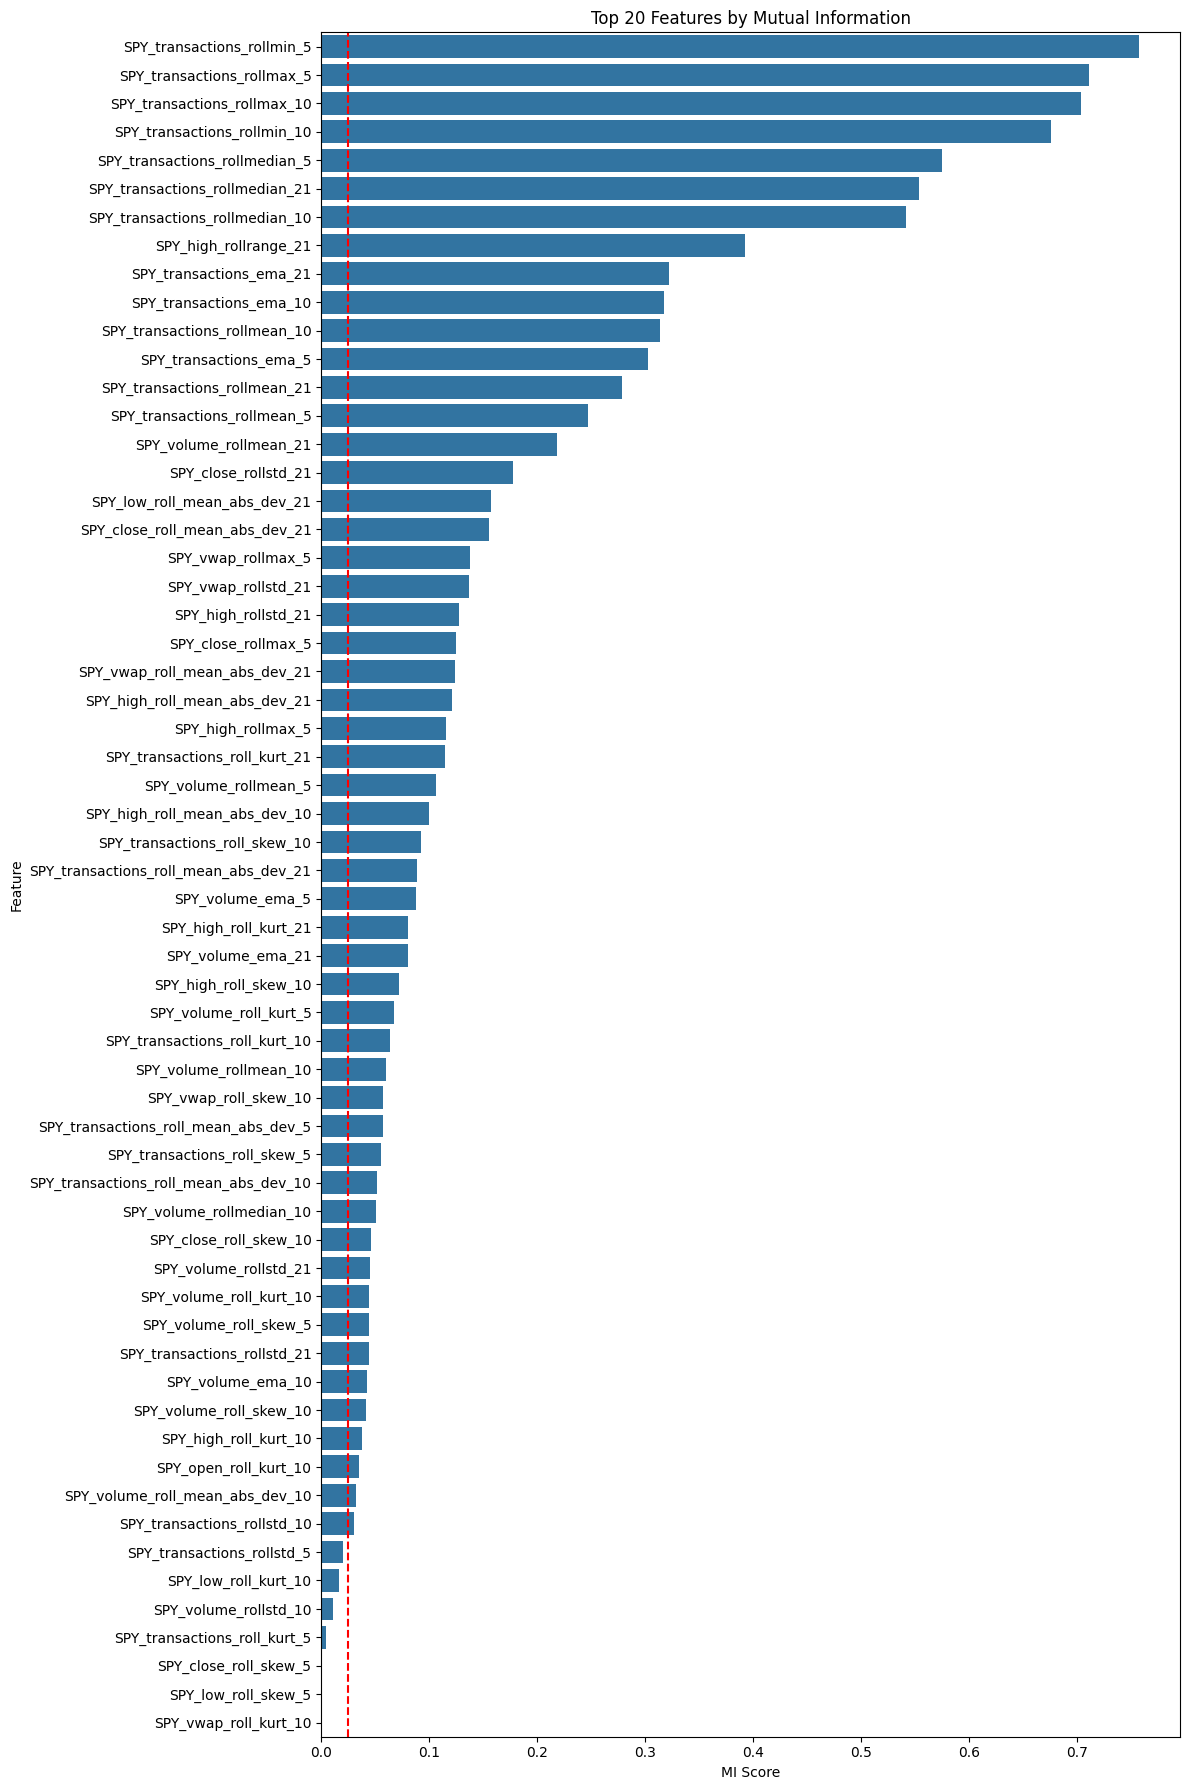

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 18))
sns.barplot(x='MI Score', y='Feature', data=mi_df)
plt.axvline(x=0.025, color="red", linestyle="--", label="Noise Threshold")
plt.title("Top 20 Features by Mutual Information")
plt.tight_layout()
plt.show()


Drop features with less than 0.05 Mutual Information score.

In [34]:
# Keep only features with MI ≥ 0.025
selected_features = mi_df[mi_df['MI Score'] > 0.025]['Feature'].to_list()

train_filtered = train_df[selected_features + ['regime']].copy()
test_filtered = test_df[selected_features + ['regime']].copy()

print(f"Original features: {train_df.shape[1]}")
print(f"Features kept: {len(selected_features)}")
print("Top kept features:", selected_features[:10])


Original features: 61
Features kept: 53
Top kept features: ['SPY_transactions_rollmin_5', 'SPY_transactions_rollmax_5', 'SPY_transactions_rollmax_10', 'SPY_transactions_rollmin_10', 'SPY_transactions_rollmedian_5', 'SPY_transactions_rollmedian_21', 'SPY_transactions_rollmedian_10', 'SPY_high_rollrange_21', 'SPY_transactions_ema_21', 'SPY_transactions_ema_10']


Using mutual information we reduced the features from 61 to 53. 

#### SAVE THE DATA 
Lets save the final train and test datasets. 

In [35]:
train_filtered.to_csv("../../data/generated_data/train.csv", index=False)
test_filtered.to_csv("../../data/generated_data/test.csv", index=False)